In [1]:
import pandas as pd
import psycopg2
from psycopg2 import Error
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
from keras import models
from keras.models import sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('/Users/muham/Machine-Learning/Sales-Forecasting/clean_df.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841600 entries, 0 to 841599
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Unnamed: 0            841600 non-null  int64 
 1   posting_date          841600 non-null  object
 2   posting_month         841600 non-null  int64 
 3   posting_year          841600 non-null  int64 
 4   material              841600 non-null  int64 
 5   bill_qty_sku          841600 non-null  int64 
 6   unit_price_penjualan  841600 non-null  int64 
 7   total_discount        841600 non-null  int64 
 8   total_penjualan       841600 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 57.8+ MB


In [3]:
df = df.drop("Unnamed: 0", axis=1)
df.head()

,posting_date,posting_month,posting_year,material,bill_qty_sku,unit_price_penjualan,total_discount,total_penjualan
0,2021-02-15,2,2021,11000385,24,7950,9540,181260
1,2021-02-15,2,2021,11000187,1000,19328,0,193280
2,2021-02-15,2,2021,11000202,100,30590,0,30590
3,2021-02-15,2,2021,11000056,100,58760,0,58760
4,2021-02-15,2,2021,11000248,100,46606,0,46606


In [4]:
df['posting_date'] = pd.to_datetime(df['posting_date'])
material_data = df.groupby(['material','posting_date']).agg({'bill_qty_sku':'sum', 'total_penjualan':'sum', 'material':'first', 'posting_date':'first'})
material_data.head()

bill_qty_sku  total_penjualan  material posting_date
material posting_date                                                      
11000000 2021-01-07             100            55567  11000000   2021-01-07
         2021-01-08            1900          1027155  11000000   2021-01-08
         2021-01-09            2700          1430016  11000000   2021-01-09
         2021-01-11            5700          2938105  11000000   2021-01-11
         2021-01-12           23200         11973854  11000000   2021-01-12

In [5]:
material_data.tail()

bill_qty_sku  total_penjualan  material posting_date
material posting_date                                                      
11002182 2021-05-28            1260         73216800  11002182   2021-05-28
         2021-05-29             700         40676000  11002182   2021-05-29
         2021-05-31            1400         81352000  11002182   2021-05-31
11002198 2021-04-30             250         19633725  11002198   2021-04-30
11002204 2021-05-11          499773     115739930205  11002204   2021-05-11

In [6]:
data_11000000 = material_data.loc[(material_data['material']==11000000)]
data_11000000.head()

bill_qty_sku  total_penjualan  material posting_date
material posting_date                                                      
11000000 2021-01-07             100            55567  11000000   2021-01-07
         2021-01-08            1900          1027155  11000000   2021-01-08
         2021-01-09            2700          1430016  11000000   2021-01-09
         2021-01-11            5700          2938105  11000000   2021-01-11
         2021-01-12           23200         11973854  11000000   2021-01-12

In [7]:
data_11000000.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 113 entries, (11000000, Timestamp('2021-01-07 00:00:00')) to (11000000, Timestamp('2021-05-31 00:00:00'))
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bill_qty_sku     113 non-null    int64         
 1   total_penjualan  113 non-null    int64         
 2   material         113 non-null    int64         
 3   posting_date     113 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 9.2 KB


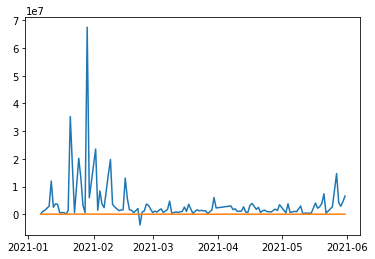

In [8]:
plt.plot(data_11000000['posting_date'],data_11000000['total_penjualan'])
plt.plot(data_11000000['posting_date'],data_11000000['bill_qty_sku'])

In [154]:
material_sales = data_11000000
material_sales = material_sales.reset_index(drop=True)

In [155]:
material_sales['diff'] = material_sales['total_penjualan'].diff()
material_sales = material_sales.drop(['posting_date','bill_qty_sku','total_penjualan','material'],axis =1)
material_sales.head()
material_sales.info()
supervised_data = material_sales

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   diff    112 non-null    float64
dtypes: float64(1)
memory usage: 1.0 KB


In [156]:
for i in range(1,55):
    col_name = 'day_' + str(i)
    supervised_data[col_name] = material_sales['diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 55 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   diff    58 non-null     float64
 1   day_1   58 non-null     float64
 2   day_2   58 non-null     float64
 3   day_3   58 non-null     float64
 4   day_4   58 non-null     float64
 5   day_5   58 non-null     float64
 6   day_6   58 non-null     float64
 7   day_7   58 non-null     float64
 8   day_8   58 non-null     float64
 9   day_9   58 non-null     float64
 10  day_10  58 non-null     float64
 11  day_11  58 non-null     float64
 12  day_12  58 non-null     float64
 13  day_13  58 non-null     float64
 14  day_14  58 non-null     float64
 15  day_15  58 non-null     float64
 16  day_16  58 non-null     float64
 17  day_17  58 non-null     float64
 18  day_18  58 non-null     float64
 19  day_19  58 non-null     float64
 20  day_20  58 non-null     float64
 21  day_21  58 non-null     float64
 22  day_

In [157]:
test_data = supervised_data[-54:]
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(test_data)
test_data = scaler.transform(test_data)
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_test = y_test.ravel()

In [158]:
X_test.shape

(54, 54)

In [92]:
sales_dates = data_11000000['posting_date'][-29:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
data_11000000clean = data_11000000.reset_index(drop=True)
act_sales = data_11000000clean['total_penjualan'][-30:].to_list()

In [33]:
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Reshape((29,29,1)))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(LSTM(4, batch_input_shape=(1, X_train_lstm.shape[1], X_test_lstm.shape[2])))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(1e-3))

In [34]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Reshape((29,29,1)))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(LSTM(4, batch_input_shape=(1, X_train_lstm.shape[1], X_test_lstm.shape[2])))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',
optimizer = keras.optimizers.Adam(1e-3))

In [35]:
model.compile(loss='mean_squared_error',
optimizer = keras.optimizers.Adam(1e-3))
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 195:
        lr *= 0.5e-4
    elif epoch > 100:
        lr *= 1e-3
    elif epoch > 50:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
      # if epoch < 40:
    #   return 0.01
      # else:
      #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  

In [36]:
history = model.fit(X_train_lstm, y_train, 
                    epochs=50, 
                    batch_size=1, 
                    validation_data=(X_test_lstm, y_test), 
                    callbacks=[lrdecay])

Epoch 1/50
54/54 [==============================] - 1s 8ms/step - loss: 0.1326 - val_loss: 0.1716 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - 0s 3ms/step - loss: 0.1066 - val_loss: 0.1622 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - 0s 3ms/step - loss: 0.0944 - val_loss: 0.1574 - lr: 0.0010
Epoch 4/50
54/54 [==============================] - 0s 3ms/step - loss: 0.0876 - val_loss: 0.1554 - lr: 0.0010
Epoch 5/50
54/54 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.1541 - lr: 0.0010
Epoch 6/50
54/54 [==============================] - 0s 3ms/step - loss: 0.0805 - val_loss: 0.1533 - lr: 0.0010
Epoch 7/50
54/54 [==============================] - 0s 3ms/step - loss: 0.0781 - val_loss: 0.1529 - lr: 0.0010
Epoch 8/50
54/54 [==============================] - 0s 3ms/step - loss: 0.0760 - val_loss: 0.1526 - lr: 0.0010
Epoch 9/50
54/54 [==============================] - 0s 3ms/step - loss: 0.0742 - val_loss: 0.1523 - lr: 0.0010
E

In [159]:
lstm_pred = model.predict(X_test_lstm, batch_size=1)
lstm_pred = lstm_pred.reshape(-1,1)
lstm_pred_test_set = np.concatenate([lstm_pred,X_test], axis=1)
lstm_pred_test_set = scaler.inverse_transform(lstm_pred_test_set)
result_list = []
for index in range(0, len(lstm_pred_test_set)):
    result_list.append(lstm_pred_test_set[index][0] + 0)
lstm_pred_series = pd.Series(result_list, name='lstm_pred')
predict_df = predict_df.merge(lstm_pred_series, left_index=True, right_index=True)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 29 and the array at index 1 has size 54

In [136]:
lstm_pred.shape

(29, 1)

In [108]:
lstm_pred = model.predict(X_test_lstm, batch_size=1)
lstm_pred = lstm_pred.reshape(-1,1)
lstm_pred_test_set = np.concatenate([lstm_pred,X_test], axis=1)
lstm_pred_test_set = scaler.inverse_transform(lstm_pred_test_set)
result_list = []
for index in range(0, len(lstm_pred_test_set)):
    result_list.append(lstm_pred_test_set[index][0] + act_sales[index])
lstm_pred_series = pd.Series(result_list, name='lstm_pred')
predict_df = predict_df.merge(lstm_pred_series, left_index=True, right_index=True)

In [105]:
predict_df['posting_date'] = pd.date_range(start='2021-06-01', end='2021-06-29', freq='D')
predict_result = predict_df
predict_result = predict_result.merge(data_11000000)

ValueError: 'posting_date' is both an index level and a column label, which is ambiguous.

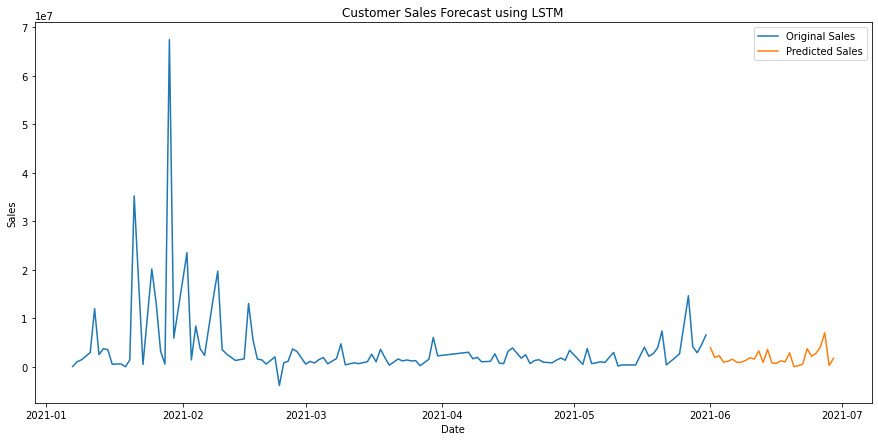

In [109]:
plt.figure(figsize=(15,7))
plt.plot(data_11000000clean['posting_date'], data_11000000['total_penjualan'])
plt.plot(predict_df['posting_date'], predict_df['lstm_pred'])
plt.title("Customer Sales Forecast using LSTM")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

In [70]:
tf.keras.models.save_model(model, '/Users/muham/Machine-Learning/Sales-Forecasting/Model/LSTM_model_total-lagged.h5')

In [19]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   posting_date  6 non-null      datetime64[ns]
 1   lstm_pred     6 non-null      float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 224.0 bytes


In [28]:
material_sales.tail()

,sales_diff
108,11958419.0
109,-10491018.0
110,-1270560.0
111,1662643.0
112,2013670.0


In [29]:
predict_df.tail()

,posting_date,lstm_pred
1,2021-05-27,2.840790e+06
2,2021-05-28,9.936084e+06
3,2021-05-29,7.132821e+06
4,2021-05-30,4.118824e+06
5,2021-05-31,5.726198e+06


In [107]:
predict_df_shifted.tail()

,posting_date,lstm_pred_x,lstm_pred_y,lstm_pred
1,2021-05-27,1.475102e+07,2.712790e+06,1.475102e+07
2,2021-05-28,4.115766e+06,1.475102e+07,4.115766e+06
3,2021-05-29,2.812021e+06,4.115766e+06,2.812021e+06
4,2021-05-30,4.536234e+06,2.812021e+06,4.536234e+06
5,2021-05-31,NaN,4.536234e+06,NaN


In [108]:
predict_df.tail()

,posting_date,lstm_pred_x,lstm_pred_y,lstm_pred
1,2021-05-27,1.475102e+07,2.712790e+06,1.475102e+07
2,2021-05-28,4.115766e+06,1.475102e+07,4.115766e+06
3,2021-05-29,2.812021e+06,4.115766e+06,2.812021e+06
4,2021-05-30,4.536234e+06,2.812021e+06,4.536234e+06
5,2021-05-31,NaN,4.536234e+06,NaN


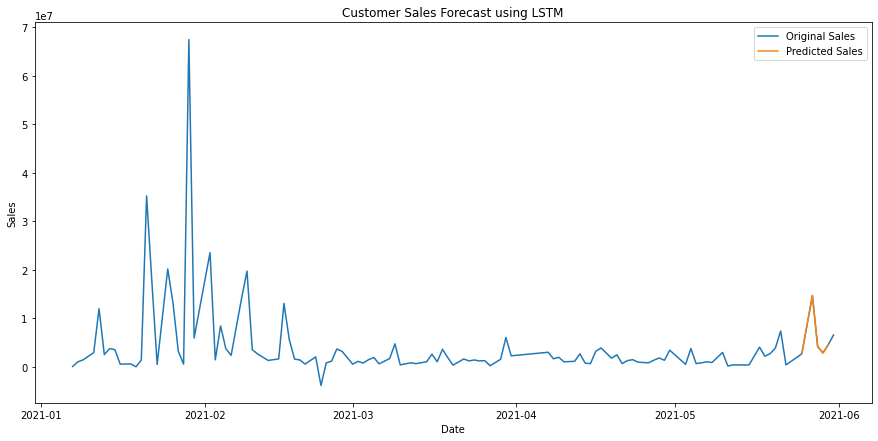

In [109]:
plt.figure(figsize=(15,7))
plt.plot(data_11000000clean['posting_date'], data_11000000clean['total_penjualan'])
plt.plot(predict_df_shifted['posting_date'], predict_df_shifted['lstm_pred'])
plt.title("Customer Sales Forecast using LSTM")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()